In [1]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", module="IPython")

root_dir = Path().absolute()
# Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
if root_dir.parts[-1:] == ('notebooks',):
    root_dir = Path(*root_dir.parts[:-1])
    sys.path.append(str(root_dir))
if root_dir.parts[-1:] == ('ccfraud',):
    root_dir = Path(*root_dir.parts[:-1])
    sys.path.append(str(root_dir))
root_dir = str(root_dir) 

print(f"Root dir: {root_dir}")

# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Root dir: /home/jdowling/Projects/mlfs-book
HopsworksSettings initialized!


In [2]:
import hopsworks
import pandas as pd

proj = hopsworks.login()
fs = proj.get_feature_store()
mr = proj.get_model_registry()

2026-01-13 20:49:34,365 INFO: Initializing external client
2026-01-13 20:49:34,366 INFO: Base URL: https://eu-west.cloud.hopsworks.ai:443
2026-01-13 20:49:35,224 INFO: Python Engine initialized.

Logged in to project, explore it here https://eu-west.cloud.hopsworks.ai:443/p/120


In [3]:
merchant_fg = fs.get_feature_group("merchant_details", version=1)
account_fg = fs.get_feature_group("account_details", version=1)
bank_fg = fs.get_feature_group("bank_details", version=1)
card_fg = fs.get_feature_group("card_details", version=1)
cc_trans_aggs_fg = fs.get_feature_group("cc_trans_aggs_fg", version=1)
cc_trans_fg = fs.get_feature_group("cc_trans_fg", version=1)

In [24]:
subtree1 = cc_trans_aggs_fg.select_except(['t_id','cc_num','account_id','bank_id','event_time'])\
    .join(account_fg.select(['debt_end_prev_month']), on="account_id", join_type="inner")\
    .join(bank_fg.select(['credit_rating', 'days_since_bank_cr_changed', 'country']), on="bank_id", join_type="inner")

In [25]:
df = subtree1.read()
df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (6.73s) 


,num_trans_last_10_mins,sum_trans_last_10_mins,num_trans_last_hour,sum_trans_last_hour,num_trans_last_day,sum_trans_last_day,num_trans_last_week,sum_trans_last_week,prev_card_present,prev_ip_transaction,prev_ts_transaction,debt_end_prev_month,credit_rating,days_since_bank_cr_changed,country
0,1,13.98,1,13.98,1,13.98,1,13.98,False,186.51.180.146,NaT,1484.26,9,61,Indonesia
1,1,47.46,1,47.46,1,47.46,1,47.46,True,72.244.158.175,NaT,683.48,9,61,Indonesia
2,1,66.46,1,66.46,1,66.46,1,66.46,True,82.47.164.28,NaT,543.30,9,61,Indonesia
3,1,13.71,1,13.71,1,13.71,1,13.71,True,61.139.113.49,NaT,4476.09,9,61,Indonesia
4,1,35.36,1,35.36,1,35.36,1,35.36,False,189.196.235.21,NaT,-53.88,9,61,Indonesia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456754,1,31.36,1,31.36,6,525.20,56,3434.04,True,14.66.246.73,2026-01-12 22:17:12,3185.13,10,262,Mexico
456755,1,4.36,1,4.36,5,303.34,45,2905.84,True,92.193.7.25,2026-01-12 18:48:30,2425.80,10,262,Mexico
456756,1,16.57,1,16.57,6,264.06,41,1888.28,False,115.31.143.30,2026-01-12 11:52:29,3238.68,10,262,Mexico
456757,1,11.35,1,11.35,7,384.31,50,3645.84,True,88.80.194.232,2026-01-12 22:32:14,1723.58,10,262,Mexico


In [26]:
selection = cc_trans_fg.select_except(['t_id', 'cc_num', 'merchant_id', 'account_id', 'ip_address', 'ts'])\
    .join(merchant_fg.select_features(), prefix="merchant_", on="merchant_id")\
    .join(subtree1, on="cc_num")

2026-01-13 22:06:16,497 INFO: Using ['category', 'country', 'cnt_chrgeback_prev_day', 'cnt_chrgeback_prev_week', 'cnt_chrgeback_prev_month'] from feature group `merchant_details` as features for the query. To include primary key and event time use `select_all`.


In [27]:
df = selection.read()
df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (11.20s) 


,amount,time_since_last_trans,days_to_card_expiry,is_fraud,haversine_distance,merchant_category,merchant_country,merchant_cnt_chrgeback_prev_day,merchant_cnt_chrgeback_prev_week,merchant_cnt_chrgeback_prev_month,...,sum_trans_last_day,num_trans_last_week,sum_trans_last_week,prev_card_present,prev_ip_transaction,prev_ts_transaction,debt_end_prev_month,credit_rating,days_since_bank_cr_changed,country
0,615.89,-2590795,0,False,True,Pet Supplies,Japan,0.50,3.19,15.80,...,615.89,1,615.89,True,211.144.230.106,NaT,1310.69,10,40,Germany
1,45.31,-2569702,0,False,True,Electronics,China,2.30,13.17,61.51,...,45.31,1,45.31,False,110.101.200.123,NaT,2907.37,10,40,Germany
2,24.11,-2578949,0,False,True,Education,Germany,0.47,3.45,12.53,...,24.11,1,24.11,True,78.12.132.42,NaT,1442.48,10,40,Germany
3,160.20,-2589467,0,False,True,Gas Stations,Belgium,4.13,26.89,115.14,...,160.20,1,160.20,True,79.102.13.102,NaT,1012.91,10,40,Germany
4,6.64,-2587400,0,False,True,Education,Germany,0.47,3.45,12.53,...,6.64,1,6.64,True,91.81.90.249,NaT,3171.56,10,40,Germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457145,31.36,5607,0,False,True,Beauty,South Korea,0.42,3.06,14.65,...,525.20,56,3434.04,True,14.66.246.73,2026-01-12 22:17:12,3185.13,10,262,Mexico
457146,4.36,18275,0,False,True,Books,United Kingdom,0.51,3.01,13.95,...,303.34,45,2905.84,True,92.193.7.25,2026-01-12 18:48:30,2425.80,10,262,Mexico
457147,16.57,27167,0,False,True,Beauty,South Korea,0.42,3.06,14.65,...,264.06,41,1888.28,False,115.31.143.30,2026-01-12 11:52:29,3238.68,10,262,Mexico
457148,11.35,4928,0,False,True,Entertainment,France,0.38,2.34,13.21,...,384.31,50,3645.84,True,88.80.194.232,2026-01-12 22:32:14,1723.58,10,262,Mexico


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457150 entries, 0 to 457149
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   amount                             457150 non-null  float64       
 1   time_since_last_trans              457150 non-null  int64         
 2   days_to_card_expiry                457150 non-null  int64         
 3   is_fraud                           457150 non-null  bool          
 4   haversine_distance                 457150 non-null  bool          
 5   merchant_category                  437338 non-null  object        
 6   merchant_country                   437338 non-null  object        
 7   merchant_cnt_chrgeback_prev_day    437338 non-null  float64       
 8   merchant_cnt_chrgeback_prev_week   437338 non-null  float64       
 9   merchant_cnt_chrgeback_prev_month  437338 non-null  float64       
 10  num_trans_last_10_mi

In [41]:
fv = fs.get_or_create_feature_view(name="cc_fraud_fv", 
                                   version=1, 
                                   description="features for a credit card fraud prediction model",
                                   query=selection,
                                   labels=['is_fraud'],
                                   inference_helper_columns=['prev_card_present','prev_ip_transaction','prev_ts_transaction']
                                  )

Feature view created successfully, explore it at 
https://eu-west.cloud.hopsworks.ai:443/p/120/fs/68/fv/cc_fraud_fv/version/1


In [42]:
test_start="2025-12-28 00:00"
X_train, X_test, y_train, y_test = fv.train_test_split(test_start=test_start)
X_train

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (10.57s) 
2026-01-13 22:37:32,632 INFO: Computing insert statistics
2026-01-13 22:37:32,947 INFO: Computing insert statistics


,amount,time_since_last_trans,days_to_card_expiry,haversine_distance,merchant_category,merchant_country,merchant_cnt_chrgeback_prev_day,merchant_cnt_chrgeback_prev_week,merchant_cnt_chrgeback_prev_month,num_trans_last_10_mins,...,num_trans_last_hour,sum_trans_last_hour,num_trans_last_day,sum_trans_last_day,num_trans_last_week,sum_trans_last_week,debt_end_prev_month,credit_rating,days_since_bank_cr_changed,country
0,615.89,-2590795,0,True,Pet Supplies,Japan,0.50,3.19,15.80,1,...,1,615.89,1,615.89,1,615.89,1310.69,10,40,Germany
1,45.31,-2569702,0,True,Electronics,China,2.30,13.17,61.51,1,...,1,45.31,1,45.31,1,45.31,2907.37,10,40,Germany
2,24.11,-2578949,0,True,Education,Germany,0.47,3.45,12.53,1,...,1,24.11,1,24.11,1,24.11,1442.48,10,40,Germany
3,160.20,-2589467,0,True,Gas Stations,Belgium,4.13,26.89,115.14,1,...,1,160.20,1,160.20,1,160.20,1012.91,10,40,Germany
4,6.64,-2587400,0,True,Education,Germany,0.47,3.45,12.53,1,...,1,6.64,1,6.64,1,6.64,3171.56,10,40,Germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453758,102.97,2762,0,False,Beauty,South Korea,0.42,3.06,14.65,1,...,2,199.55,9,467.51,53,3947.18,3238.68,10,262,Mexico
453759,9.89,10473,0,False,Department Stores,Canada,2.24,14.79,53.95,1,...,1,9.89,7,150.82,27,1253.53,-463.20,10,262,Mexico
453760,24.84,198,0,False,Beauty,Mexico,8.43,54.55,297.70,2,...,2,34.73,8,175.66,28,1278.37,-463.20,10,262,Mexico
453761,7.57,18531,0,True,Insurance,Japan,0.93,6.57,29.12,1,...,1,7.57,10,599.20,63,4215.85,5447.09,10,262,Mexico


In [43]:
X_test

,amount,time_since_last_trans,days_to_card_expiry,haversine_distance,merchant_category,merchant_country,merchant_cnt_chrgeback_prev_day,merchant_cnt_chrgeback_prev_week,merchant_cnt_chrgeback_prev_month,num_trans_last_10_mins,...,num_trans_last_hour,sum_trans_last_hour,num_trans_last_day,sum_trans_last_day,num_trans_last_week,sum_trans_last_week,debt_end_prev_month,credit_rating,days_since_bank_cr_changed,country
3650,5.32,1692,0,True,Restaurants,Germany,4.47,35.40,157.15,1,...,2,68.17,6,237.56,39,1843.27,1442.48,10,40,Germany
3651,16.67,11417,0,False,Travel,China,1.52,11.52,40.64,1,...,1,16.67,7,328.22,43,2430.42,898.57,10,40,Germany
3652,8.43,23933,0,True,Travel,China,1.52,11.52,40.64,1,...,1,8.43,10,191.79,58,2737.09,4417.68,10,40,Germany
3653,7.83,49994,0,True,Beauty,Mexico,8.43,54.55,297.70,1,...,1,7.83,2,67.93,42,4761.43,4998.21,10,40,Germany
3654,97.50,1965,0,False,Department Stores,Canada,2.24,14.79,53.95,1,...,2,330.32,6,496.31,45,4131.78,2012.75,10,40,Germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457145,31.36,5607,0,True,Beauty,South Korea,0.42,3.06,14.65,1,...,1,31.36,6,525.20,56,3434.04,3185.13,10,262,Mexico
457146,4.36,18275,0,True,Books,United Kingdom,0.51,3.01,13.95,1,...,1,4.36,5,303.34,45,2905.84,2425.80,10,262,Mexico
457147,16.57,27167,0,True,Beauty,South Korea,0.42,3.06,14.65,1,...,1,16.57,6,264.06,41,1888.28,3238.68,10,262,Mexico
457148,11.35,4928,0,True,Entertainment,France,0.38,2.34,13.21,1,...,1,11.35,7,384.31,50,3645.84,1723.58,10,262,Mexico


In [44]:
y_train.value_counts()

is_fraud
False       201152
True          1072
Name: count, dtype: int64

In [45]:
X_train_processed = X_train
X_test_processed = X_test
y_train_processed = y_train
y_test_processed = y_test

In [46]:
# Create Preprocessing Pipeline
# Use sklearn Pipeline for imputation and encoding (production-ready for inference)

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
import numpy as np

print("CREATING PREPROCESSING PIPELINE")
print("Missing values before preprocessing:")
print(X_train_processed.isnull().sum()[X_train_processed.isnull().sum() > 0])

# Identify numeric and categorical columns
categorical_features = ['merchant_category', 'merchant_country', 'country']
numeric_features = [col for col in X_train_processed.columns if col not in categorical_features]

print(f"\nNumeric features ({len(numeric_features)}): {numeric_features[:5]}...")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Create preprocessing pipeline with both imputation and encoding
# Numeric pipeline: just impute missing values
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Categorical pipeline: impute missing values then encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='UNKNOWN')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Combine into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    verbose_feature_names_out=False
)

# Fit and transform the data
X_train_transformed = preprocessor.fit_transform(X_train_processed)
X_test_transformed = preprocessor.transform(X_test_processed)

# Get feature names after transformation
feature_names_out = preprocessor.get_feature_names_out()

# Convert back to DataFrame
X_train_processed = pd.DataFrame(X_train_transformed, columns=feature_names_out, index=X_train_processed.index)
X_test_processed = pd.DataFrame(X_test_transformed, columns=feature_names_out, index=X_test_processed.index)

print("\nAfter preprocessing pipeline:")
print(f"  Missing values: {X_train_processed.isnull().sum().sum()}")
print(f"  Train shape: {X_train_processed.shape}")
print(f"  Test shape: {X_test_processed.shape}")
print("\nPreprocessing pipeline (imputation + encoding) ready for inference!")

CREATING PREPROCESSING PIPELINE
Missing values before preprocessing:
merchant_category                    18115
merchant_country                     18115
merchant_cnt_chrgeback_prev_day      18115
merchant_cnt_chrgeback_prev_week     18115
merchant_cnt_chrgeback_prev_month    18115
dtype: int64

Numeric features (18): ['amount', 'time_since_last_trans', 'days_to_card_expiry', 'haversine_distance', 'merchant_cnt_chrgeback_prev_day']...
Categorical features (3): ['merchant_category', 'merchant_country', 'country']

After preprocessing pipeline:
  Missing values: 0
  Train shape: (202224, 21)
  Test shape: (254926, 21)

Preprocessing pipeline (imputation + encoding) ready for inference!


In [47]:
# Verify Preprocessing Pipeline
# Check that all transformations were applied correctly

print("=" * 80)
print("PREPROCESSING PIPELINE VERIFICATION")
print("=" * 80)

# Check for any remaining missing values
print(f"\nMissing values: {X_train_processed.isnull().sum().sum()}")

# Show pipeline structure
print("\nPreprocessing Pipeline Structure:")
print(preprocessor)

print("\nAll preprocessing complete!")
print(f"  ✓ Missing values imputed")
print(f"  ✓ Categorical features encoded")
print(f"  ✓ Pipeline can be saved and reused for inference")

PREPROCESSING PIPELINE VERIFICATION

Missing values: 0

Preprocessing Pipeline Structure:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['amount', 'time_since_last_trans',
                                  'days_to_card_expiry', 'haversine_distance',
                                  'merchant_cnt_chrgeback_prev_day',
                                  'merchant_cnt_chrgeback_prev_week',
                                  'merchant_cnt_chrgeback_prev_month',
                                  'num_trans_last_10_mins',
                                  'sum_trans_last_10_mins',
                                  'num_trans_last_...
                                  'num_trans_last_week', 'sum_trans_last_week',
                                  'debt_end_prev_month', 'credit_rating',
                                  'd

In [48]:
# Calculate scale_pos_weight
# This is the key parameter for handling class imbalance in XGBoost

n_negative = (y_train["is_fraud"] == False).sum()
n_positive = (y_train["is_fraud"] == True).sum()
scale_pos_weight = n_negative / n_positive

print("=" * 80)
print("CLASS IMBALANCE ANALYSIS")
print("=" * 80)
print(f"Negative samples (non-fraud): {n_negative:,}")
print(f"Positive samples (fraud):     {n_positive:,}")
print(f"Imbalance ratio:              {scale_pos_weight:.2f}:1")
print(f"\nscale_pos_weight parameter:   {scale_pos_weight:.2f}")
print("\nThis parameter tells XGBoost to give ~{:.0f}x more weight to fraud cases".format(scale_pos_weight))
print("during training to compensate for the severe class imbalance.")

CLASS IMBALANCE ANALYSIS
Negative samples (non-fraud): 201,152
Positive samples (fraud):     1,072
Imbalance ratio:              187.64:1

scale_pos_weight parameter:   187.64

This parameter tells XGBoost to give ~188x more weight to fraud cases
during training to compensate for the severe class imbalance.


In [49]:
# Train XGBoost Model
# Configure XGBoost for imbalanced binary classification

import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Configure XGBoost with scale_pos_weight for class imbalance
xgb_classifier = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    max_depth=6,                        # Control overfitting
    learning_rate=0.1,                  # Standard learning rate
    n_estimators=100,                   # Number of boosting rounds
    eval_metric='aucpr',                # PR-AUC: best metric for imbalanced data
    early_stopping_rounds=10,           # Stop if no improvement for 10 rounds
    random_state=42,                    # Reproducibility
    use_label_encoder=False,            # Avoid deprecation warning
    enable_categorical=False            # We pre-encoded categoricals
)

# Create evaluation set for early stopping
eval_set = [(X_train_processed, y_train), (X_test_processed, y_test)]

print("=" * 80)
print("TRAINING XGBOOST MODEL")
print("=" * 80)
print("Model configuration:")
print(f"  scale_pos_weight:      {scale_pos_weight:.2f}")
print(f"  max_depth:             {xgb_classifier.max_depth}")
print(f"  learning_rate:         {xgb_classifier.learning_rate}")
print(f"  n_estimators:          {xgb_classifier.n_estimators}")
print(f"  eval_metric:           {xgb_classifier.eval_metric}")
print(f"  early_stopping_rounds: 10")
print("\nTraining in progress...")

# Train the model
xgb_classifier.fit(
    X_train_processed, 
    y_train.values.ravel(),
    eval_set=eval_set,
    verbose=False
)

print("\nTraining complete!")
print(f"Best iteration: {xgb_classifier.best_iteration}")
print(f"Best score (AUCPR): {xgb_classifier.best_score:.4f}")

TRAINING XGBOOST MODEL
Model configuration:
  scale_pos_weight:      187.64
  max_depth:             6
  learning_rate:         0.1
  n_estimators:          100
  eval_metric:           aucpr
  early_stopping_rounds: 10

Training in progress...

Training complete!
Best iteration: 23
Best score (AUCPR): 0.7542


TOP 15 MOST IMPORTANT FEATURES
                          feature  importance
              num_trans_last_hour    0.449212
            time_since_last_trans    0.187859
                           amount    0.053977
              sum_trans_last_hour    0.040299
merchant_cnt_chrgeback_prev_month    0.031309
               haversine_distance    0.030409
 merchant_cnt_chrgeback_prev_week    0.024964
                 merchant_country    0.020712
                merchant_category    0.018812
               num_trans_last_day    0.018538
              sum_trans_last_week    0.017950
  merchant_cnt_chrgeback_prev_day    0.017585
           sum_trans_last_10_mins    0.016646
       days_since_bank_cr_changed    0.014417
                          country    0.013450


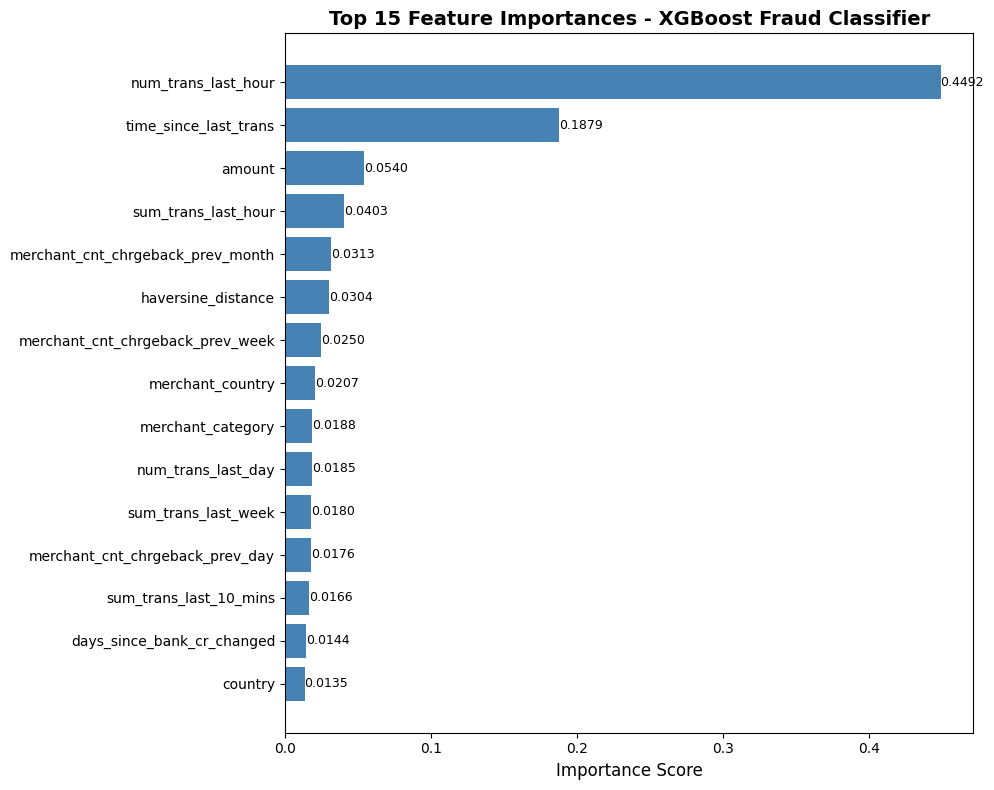


Interpretation:
Features with higher importance scores have more influence on fraud predictions.
Geographic indicators, transaction patterns, and merchant history are key fraud signals.


In [50]:
# Feature Importance
# Analyze which features are most important for fraud detection
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_processed.columns,
    'importance': xgb_classifier.feature_importances_
}).sort_values('importance', ascending=False)

# Display top 15 features
print("=" * 80)
print("TOP 15 MOST IMPORTANT FEATURES")
print("=" * 80)
print(feature_importance.head(15).to_string(index=False))

# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(15)
bars = ax.barh(top_features['feature'], top_features['importance'], color='steelblue')
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Top 15 Feature Importances - XGBoost Fraud Classifier', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, top_features['importance'])):
    ax.text(val, bar.get_y() + bar.get_height()/2, f'{val:.4f}', 
            va='center', ha='left', fontsize=9, color='black')

plt.tight_layout()
feature_imp_fig = fig  # Store for saving later
plt.show()

print("\nInterpretation:")
print("Features with higher importance scores have more influence on fraud predictions.")
print("Geographic indicators, transaction patterns, and merchant history are key fraud signals.")

In [ ]:
# Confusion Matrix
# Visualize model performance showing true/false positives and negatives

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predictions on the test set
y_pred = xgb_classifier.predict(X_test_processed)


# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
df_cm = pd.DataFrame(cm, 
                     index=['True Non-Fraud', 'True Fraud'],
                     columns=['Pred Non-Fraud', 'Pred Fraud'])

sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar_kws={'label': 'Count'})
ax.set_title('Confusion Matrix - Credit Card Fraud Detection', fontsize=14, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12)
ax.set_xlabel('Predicted', fontsize=12)

plt.tight_layout()
cm_fig = fig  # Store for saving later
plt.show()

# Print confusion matrix breakdown
print("=" * 80)
print("CONFUSION MATRIX BREAKDOWN")
print("=" * 80)
print(f"True Negatives:  {cm[0,0]:5,} (correctly identified non-fraud)")
print(f"False Positives: {cm[0,1]:5,} (non-fraud flagged as fraud)")
print(f"False Negatives: {cm[1,0]:5,} (fraud missed - CRITICAL)")
print(f"True Positives:  {cm[1,1]:5,} (correctly identified fraud)")

print("\nKey Insights:")
if cm[1,0] > 0:
    print(f"  WARNING: {cm[1,0]} fraudulent transactions were missed!")
    print(f"  This represents {cm[1,0]/(cm[1,0]+cm[1,1])*100:.1f}% of all actual frauds.")
if cm[0,1] > 0:
    print(f"  {cm[0,1]} legitimate transactions were flagged as fraud (false alarms).")
    print(f"  This is {cm[0,1]/(cm[0,0]+cm[0,1])*100:.2f}% of all legitimate transactions.")

In [55]:
# Create Model Directory
# Setup directory structure for saving model artifacts
import os

model_dir = "cc_fraud_model"
images_dir = model_dir + "/images"
os.makedirs(images_dir)

print("\nModel artifacts will be saved to:", model_dir)


Model artifacts will be saved to: cc_fraud_model


In [57]:
# Save Model Artifacts
# Save all necessary files for model inference and reproducibility

import joblib

print("=" * 80)
print("SAVING MODEL ARTIFACTS")
print("=" * 80)

# Save trained model
model_path = model_dir + "/cc_fraud_xgboost.pkl"
joblib.dump(xgb_classifier, model_path)
print(f"✓ Model saved to: {model_path}")

# Save complete preprocessing pipeline (imputation + encoding)
preprocessor_path = model_dir + "/preprocessor.pkl"
joblib.dump(preprocessor, preprocessor_path)
print(f"✓ Preprocessor pipeline saved to: {preprocessor_path}")

# Save confusion matrix image
cm_fig.savefig(images_dir + "/confusion_matrix.png", dpi=100, bbox_inches='tight')
print(f"✓ Confusion matrix saved to: {images_dir}/confusion_matrix.png")

# Save feature importance image  
feature_imp_fig.savefig(images_dir + "/feature_importance.png", dpi=100, bbox_inches='tight')
print(f"✓ Feature importance saved to: {images_dir}/feature_importance.png")

print("\n" + "=" * 80)
print("ALL ARTIFACTS SAVED SUCCESSFULLY")
print("=" * 80)
print(f"Total files: 6")
print(f"  - Model: cc_fraud_xgboost.pkl")
print(f"  - Preprocessor: preprocessor.pkl (imputation + encoding)")
print(f"  - Feature schema: feature_names.pkl")
print(f"  - Feature selection: features_to_drop.pkl")
print(f"  - Visualizations: 2 PNG files")
print("\nFor inference, load: preprocessor.pkl → transform data → model.pkl → predict")

SAVING MODEL ARTIFACTS
✓ Model saved to: cc_fraud_model/cc_fraud_xgboost.pkl
✓ Preprocessor pipeline saved to: cc_fraud_model/preprocessor.pkl
✓ Confusion matrix saved to: cc_fraud_model/images/confusion_matrix.png
✓ Feature importance saved to: cc_fraud_model/images/feature_importance.png

ALL ARTIFACTS SAVED SUCCESSFULLY
Total files: 6
  - Model: cc_fraud_xgboost.pkl
  - Preprocessor: preprocessor.pkl (imputation + encoding)
  - Feature schema: feature_names.pkl
  - Feature selection: features_to_drop.pkl
  - Visualizations: 2 PNG files

For inference, load: preprocessor.pkl → transform data → model.pkl → predict


In [60]:
# Classification Metrics
# Comprehensive evaluation with metrics appropriate for imbalanced classification

from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, precision_recall_curve, auc,
    precision_score, recall_score, f1_score
)

# Classification report
print("=" * 80)
print("CLASSIFICATION REPORT")
print("=" * 80)
report_dict = classification_report(y_test, y_pred, 
                                   target_names=['Non-Fraud', 'Fraud'],
                                   output_dict=True)
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

# Calculate key metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Precision-Recall AUC (more important than ROC-AUC for imbalanced data)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall_curve, precision_curve)

print("=" * 80)
print("KEY METRICS SUMMARY")
print("=" * 80)
print(f"PR-AUC Score:         {pr_auc:.4f}  <- More important for imbalanced data")
print(f"Precision (Fraud):    {precision:.4f}")
print(f"Recall (Fraud):       {recall:.4f}")
print(f"F1-Score (Fraud):     {f1:.4f}")

# Store metrics for model registry
metrics_dict = {
    'pr_auc': pr_auc,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'accuracy': report_dict['accuracy']
}

print("\nInterpretation:")
print(f"  - Precision: {precision*100:.1f}% of predicted frauds are actually fraudulent")
print(f"  - Recall: {recall*100:.1f}% of actual frauds were detected")
print(f"  - PR-AUC: {pr_auc:.4f} measures precision-recall tradeoff (higher is better)")

CLASSIFICATION REPORT
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.97      0.98    253765
       Fraud       0.11      0.86      0.20      1161

    accuracy                           0.97    254926
   macro avg       0.56      0.92      0.59    254926
weighted avg       1.00      0.97      0.98    254926

KEY METRICS SUMMARY
PR-AUC Score:         0.4891  <- More important for imbalanced data
Precision (Fraud):    0.1128
Recall (Fraud):       0.8648
F1-Score (Fraud):     0.1996

Interpretation:
  - Precision: 11.3% of predicted frauds are actually fraudulent
  - Recall: 86.5% of actual frauds were detected
  - PR-AUC: 0.4891 measures precision-recall tradeoff (higher is better)


In [63]:
# Register Model in Hopsworks
# Upload model to Hopsworks Model Registry for versioning and deployment

print("=" * 80)
print("REGISTERING MODEL IN HOPSWORKS")
print("=" * 80)

# Format metrics for model registry (must be strings)
metrics_for_registry = {
    'pr_auc': f"{metrics_dict['pr_auc']:.4f}",
    'precision': f"{metrics_dict['precision']:.4f}",
    'recall': f"{metrics_dict['recall']:.4f}",
    'f1_score': f"{metrics_dict['f1_score']:.4f}",
    'accuracy': f"{metrics_dict['accuracy']:.4f}",
    'scale_pos_weight': f"{scale_pos_weight:.2f}",
    'n_train_samples': str(len(y_train)),
    'n_fraud_train': str(n_positive),
    'imbalance_ratio': f"{scale_pos_weight:.2f}"
}

print("Model metadata:")
for key, value in metrics_for_registry.items():
    print(f"  {key:20s}: {value}")

model_name = "cc_fraud_xgboost_model"
# Create model in registry
cc_fraud_model = mr.python.create_model(
    name=model_name,
    metrics=metrics_for_registry,
    feature_view=fv,
    description="Credit Card Fraud Detection - XGBoost Binary Classifier with scale_pos_weight for class imbalance. "
                f"Trained on {len(y_train):,} samples with {n_positive} fraud cases. "
                f"Uses {len(X_train_processed.columns)} features after preprocessing."
)

# Upload model directory to registry
cc_fraud_model.save(model_dir)

print("\n" + "=" * 80)
print("MODEL REGISTRATION COMPLETE")
print("=" * 80)
print(f"Model name: cc_fraud_xgboost_model")
print(f"Version: {cc_fraud_model.version}")
print(f"\nExplore at: {cc_fraud_model._get_url()}")

REGISTERING MODEL IN HOPSWORKS
Model metadata:
  pr_auc              : 0.4891
  precision           : 0.1128
  recall              : 0.8648
  f1_score            : 0.1996
  accuracy            : 0.9684
  scale_pos_weight    : 187.64
  n_train_samples     : 202224
  n_fraud_train       : 1072
  imbalance_ratio     : 187.64


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/jdowling/Projects/mlfs-book/ccfraud/notebooks/cc_fraud_model/preprocessor.pkl: 0.000%|        …

Uploading /home/jdowling/Projects/mlfs-book/ccfraud/notebooks/cc_fraud_model/cc_fraud_xgboost.pkl: 0.000%|    …

Uploading /home/jdowling/Projects/mlfs-book/ccfraud/notebooks/cc_fraud_model/feature_names.pkl: 0.000%|       …

Uploading /home/jdowling/Projects/mlfs-book/ccfraud/notebooks/cc_fraud_model/images/confusion_matrix.png: 0.00…

Uploading /home/jdowling/Projects/mlfs-book/ccfraud/notebooks/cc_fraud_model/images/feature_importance.png: 0.…

Uploading /home/jdowling/Projects/mlfs-book/ccfraud/notebooks/model_schema.json: 0.000%|          | 0/2146 ela…

Model created, explore it at https://eu-west.cloud.hopsworks.ai:443/p/120/models/cc_fraud_xgboost_model/1

MODEL REGISTRATION COMPLETE
Model name: cc_fraud_xgboost_model
Version: 1


AttributeError: 'Model' object has no attribute '_get_url'

In [ ]:
ms = proj.get_model_serving()
dataset_api = proj.get_dataset_api()

In [ ]:
best_model - mr.get_best_model(name=model_name, metric="", direction="max)

# If the model I trained is better than the existing model deployment, replace it with this one
if best_model.version == cc_fraud_model.version:
    

In [ ]:
%%writefile ccfraud_predictor.py
import os
import numpy as np
import hopsworks
import joblib


class Predict(object):

    def __init__(self):
        """ Initializes the serving state, reads a trained model"""        
        # Get feature store handle
        project = hopsworks.login()
        self.mr = project.get_model_registry()
        
        # Retrieve the feature view from the model
        retrieved_model = self.mr.get_best_model(
            name=cc_fraud_model.name,
            version=cc_fraud_model.version,
        )
        self.feature_view = retrieved_model.get_feature_view()

        # Load the trained model
        self.model = joblib.load(os.environ["MODEL_FILES_PATH"] + "/xgboost_model.pkl")
        print("Initialization Complete")

    def predict(self, inputs):
        """ Serves a prediction request usign a trained model"""
        feature_vector = self.feature_view.get_feature_vector({"cc_num": inputs[0][0]})
        feature_vector = feature_vector[:-2] + feature_vector[-1:]
        
        return self.model.predict(np.asarray(feature_vector).reshape(1, -1)).tolist() # Numpy Arrays are not JSON serializable